# P5: Vechicle Detection and Tracking
In this project, the goal is to write a software pipeline to detect vehicles in a video (start with the test_video.mp4 and later implement on full project_video.mp4).

## 0. Import Packages

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
import os
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label


## (A) Cars and Non-cars Classifier

## 1. Features

### 1.1 Histograms of Color
Histogram of color captures the statistical distribution of colors and the essential tone of each image patch. By comparing histograms signatures of two images and matching the color content of one image with the other. The color histogram is particulary well suited for the problem of recognizing an object of unknow position and rotation within a scene. However, it depends only in color, it may results a false positive if the histogram of color matches with image region that has not the shape of target object, but similar color

In [2]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

The following code plots up the histograms of a car image in a bar chart per color channel

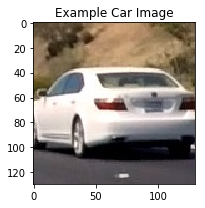

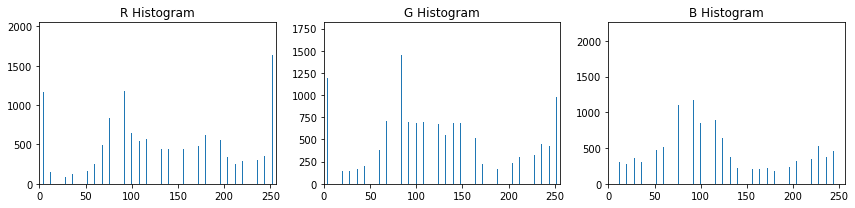

In [3]:
image = mpimg.imread('test_img.jpg')

rh, gh, bh, bincen, feature_vec = color_hist(image, nbins=32, bins_range=(0, 256))

# Plot a figure with all three bar charts
fig = plt.figure(figsize=(12,3))
plt.imshow(image)
plt.title('Example Car Image')
fig.tight_layout()
plt.show()

fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.bar(bincen, rh[0])
plt.xlim(0, 256)
plt.title('R Histogram')
plt.subplot(132)
plt.bar(bincen, gh[0])
plt.xlim(0, 256)
plt.title('G Histogram')
plt.subplot(133)
plt.bar(bincen, bh[0])
plt.xlim(0, 256)
plt.title('B Histogram')
fig.tight_layout()

plt.show()

### 1.2. Spatial Binning of Color
Spatial featues group color feature into bins spatially. It just resizes an image into very small patch (e.g. 32x32 pixels) and flatten into a single list of values

In [4]:
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    return features

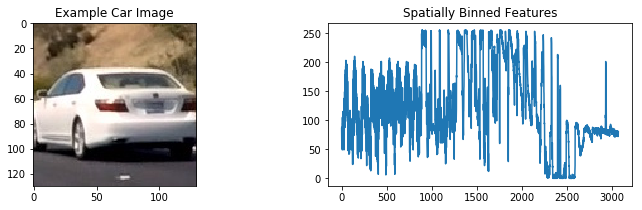

In [5]:
image = mpimg.imread('test_img.jpg')

feature_vec = bin_spatial(image, size=(32, 32))

# Plot features
fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(image)
plt.title('Example Car Image')

plt.subplot(122)
plt.plot(feature_vec)
plt.title('Spatially Binned Features')
plt.show()

### 1.3 Histogram of Oriented Gradient (HOG)

In [6]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    
    img = cv2.resize(img, (64, 64))
    
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

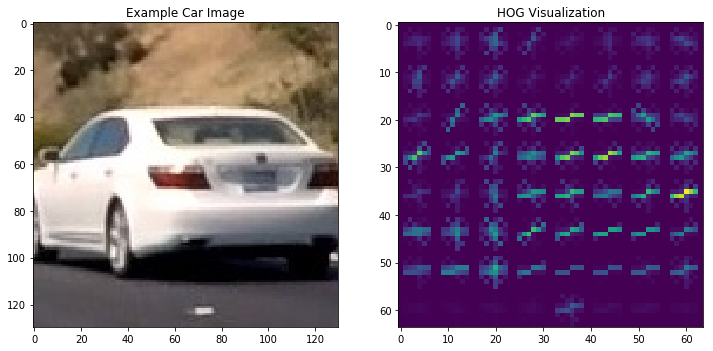

In [7]:
image = mpimg.imread('test_img.jpg')

gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

# Plot the examples
fig = plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image)
plt.title('HOG Visualization')
plt.show()


### 1.4 Combine Features

In [8]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        _, _, _, _, hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


In [9]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        file_features = single_img_features(image, color_space, spatial_size,
                            hist_bins, orient, 
                            pix_per_cell, cell_per_block, hog_channel,
                            spatial_feat, hist_feat, hog_feat)
        
        features.append(file_features.tolist())
    # Return list of feature vectors
    return features

## 2. Build a Classifier

### 2.1. Loading training data

In [10]:
# Read in car and non-car images
cars = glob.glob('./dataset/vehicles/*/*.png')
notcars = glob.glob('./dataset/non-vehicles/*/*.png')

print('Training data:')
print('Number of car images:', len(cars))
print('Number of non-car images:', len(notcars))

Training data:
Number of car images: 8792
Number of non-car images: 8968


### 2.2. Data Preparation

In [11]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()


t=time.time()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

t2 = time.time()

print(round(t2-t, 2), 'Seconds to extract HOG features...')


100.91 Seconds to extract HOG features...


In [12]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

### 2.3. Training Classifier for Cars and Non-cars

In [13]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108


In [14]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

12.77 Seconds to train SVC...


In [15]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Test Accuracy of SVC =  0.9879


In [16]:
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

My SVC predicts:  [ 0.  0.  1.  1.  1.  0.  1.  1.  1.  0.]
For these 10 labels:  [ 0.  0.  1.  1.  1.  1.  1.  1.  1.  0.]
0.002 Seconds to predict 10 labels with SVC


Saving parameters and SVC model to pickle file

In [17]:
params = {
    'color_space': color_space,
    'orient': orient,
    'pix_per_cell': pix_per_cell,
    'cell_per_block': cell_per_block,
    'hog_channel': hog_channel,
    'spatial_size': spatial_size,
    'hist_bins': hist_bins,
    'spatial_feat': spatial_feat,
    'hist_feat': hist_feat,
    'hog_feat': hog_feat
}

svc_model = {}
svc_model["svc"] = svc
svc_model["X_scaler"] = X_scaler
svc_model["params"] = params

pickle.dump( svc_model, open( "svc_model.p", "wb" ))

## (B) Car Detection

## 3. Sliding Window Search

### 3.1 Slide Windows
The sliding window search splits image into no. of smaller window, smaller square patch with some overlap. For every window, the feature vector is computed and fed into the trained SVM model.

In [18]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step)
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [19]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


The following code shows how the sliding window(size: 128x128, overlay: 50%) works

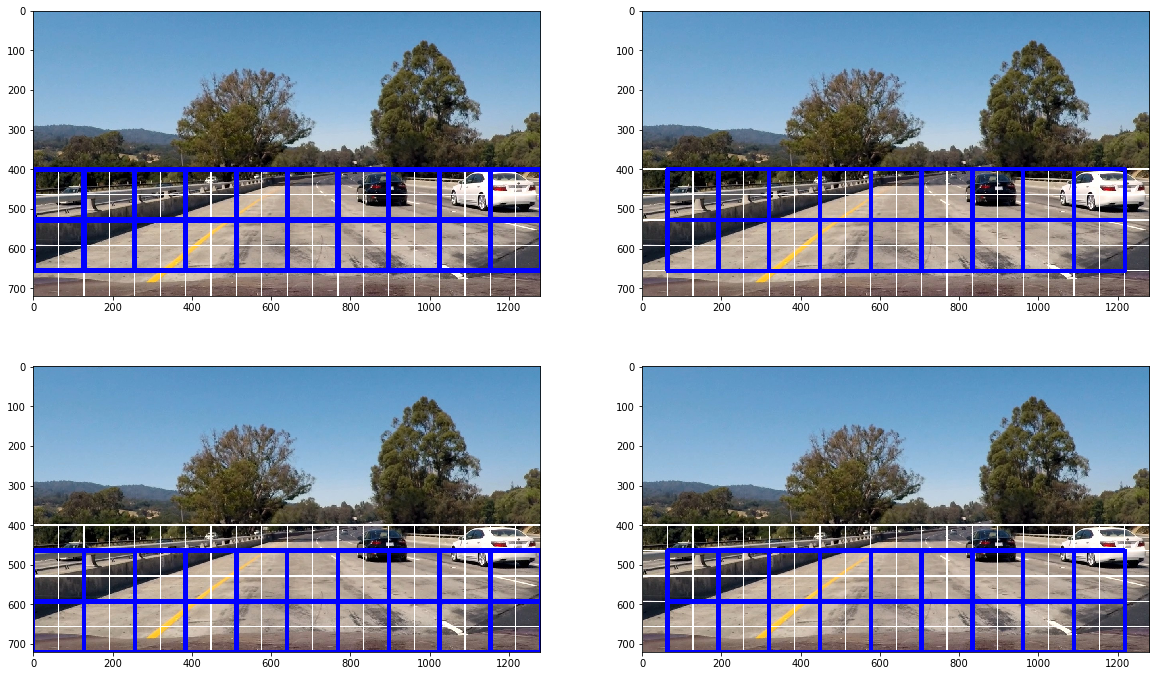

In [23]:
test_image = mpimg.imread('test_images/test1.jpg')

windows = slide_window(test_image, x_start_stop=[None, None], y_start_stop=[400, None], 
                       xy_window=(128, 128), xy_overlap=(0.5, 0.5))
boxed_image = draw_boxes(test_image, windows, (255,255,255), 2)
#
windows = slide_window(test_image, x_start_stop=[None, None], y_start_stop=[400, None], 
                       xy_window=(128, 128), xy_overlap=(0.0, 0.0))
boxed_image_1 = draw_boxes(boxed_image, windows, (0,0,255), 12)
#
windows = slide_window(test_image, x_start_stop=[64, None], y_start_stop=[400, None], 
                       xy_window=(128, 128), xy_overlap=(0.0, 0.0))
boxed_image_2 = draw_boxes(boxed_image, windows, (0,0,255), 10)
#
windows = slide_window(test_image, x_start_stop=[None, None], y_start_stop=[464, None], 
                       xy_window=(128, 128), xy_overlap=(0.0, 0.0))
boxed_image_3 = draw_boxes(boxed_image, windows, (0,0,255), 10)
#
windows = slide_window(test_image, x_start_stop=[64, None], y_start_stop=[464, None], 
                       xy_window=(128, 128), xy_overlap=(0.0, 0.0))
boxed_image_4 = draw_boxes(boxed_image, windows, (0,0,255), 10)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,12))
fig.tight_layout()

ax1.imshow(boxed_image_1)
ax2.imshow(boxed_image_2)
ax3.imshow(boxed_image_3)
ax4.imshow(boxed_image_4)

plt.show()

### 3.2. Multi-scale sliding windows

In [103]:
def multiscale_slide_windows(img):
    windows1 = slide_window(img, x_start_stop=[None, None], y_start_stop=[380, 560], 
                    xy_window=(48, 48), xy_overlap=(0.7, 0.7))

    windows2 = slide_window(img, x_start_stop=[None, None], y_start_stop=[380, 560], 
                        xy_window=(56, 56), xy_overlap=(0.8, 0.8))

    windows3 = slide_window(img, x_start_stop=[None, None], y_start_stop=[400, 640], 
                        xy_window=(72, 72), xy_overlap=(0.8, 0.8))

    windows4 = slide_window(img, x_start_stop=[None, None], y_start_stop=[400, None], 
                        xy_window=(128, 128), xy_overlap=(0.8, 0.8))

    return windows1, windows2, windows3, windows4

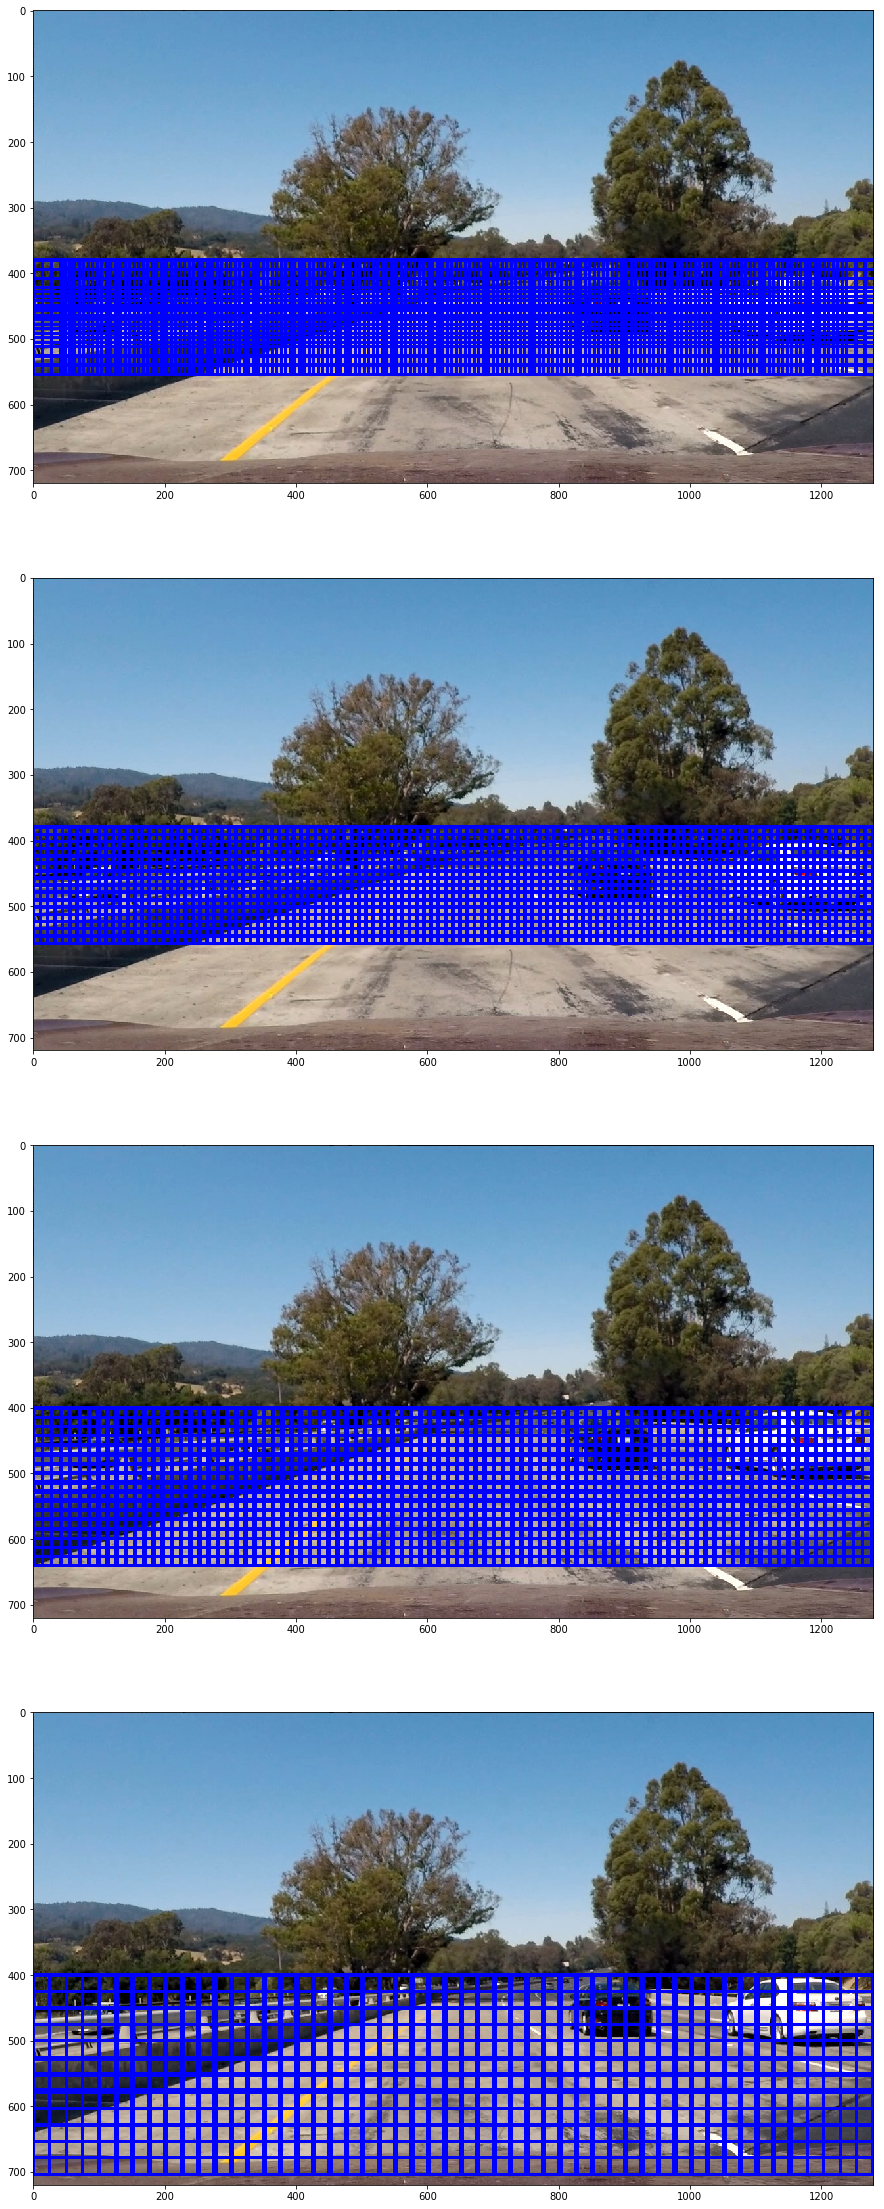

In [104]:
test_image = mpimg.imread('./test_images/test1.jpg')

windows1, windows2, windows3, windows4 = multiscale_slide_windows(test_image)

boxed_image_1 = draw_boxes(test_image, windows1, (0,0,255), 3)
boxed_image_2 = draw_boxes(test_image, windows2, (0,0,255), 3)
boxed_image_3 = draw_boxes(test_image, windows3, (0,0,255), 3)
boxed_image_4 = draw_boxes(test_image, windows4, (0,0,255), 3)

f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16,40))
fig.tight_layout()

ax1.imshow(boxed_image_1)
ax2.imshow(boxed_image_2)
ax3.imshow(boxed_image_3)
ax4.imshow(boxed_image_4)

plt.show()

### 3.3. Search and Classify

In [26]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [101]:
def search_all_sizes_windows(img):
    
    windows1, windows2, windows3, windows4 = multiscale_slide_windows(img)
        
    windows = windows1 + windows2 + windows3 + windows4
    
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    return hot_windows

Reload the saved classifier model

In [31]:
svc_model = pickle.load( open( "svc_model.p", "rb" ) )

svc = svc_model["svc"]
X_scaler = svc_model["X_scaler"]
params = svc_model["params"]

color_space = params['color_space']
orient = params['orient']
pix_per_cell = params['pix_per_cell']
cell_per_block = params['cell_per_block']
hog_channel = params['hog_channel']
spatial_size = params['spatial_size']
hist_bins = params['hist_bins']
spatial_feat = params['spatial_feat']
hist_feat = params['hist_feat']
hog_feat = params['hog_feat']

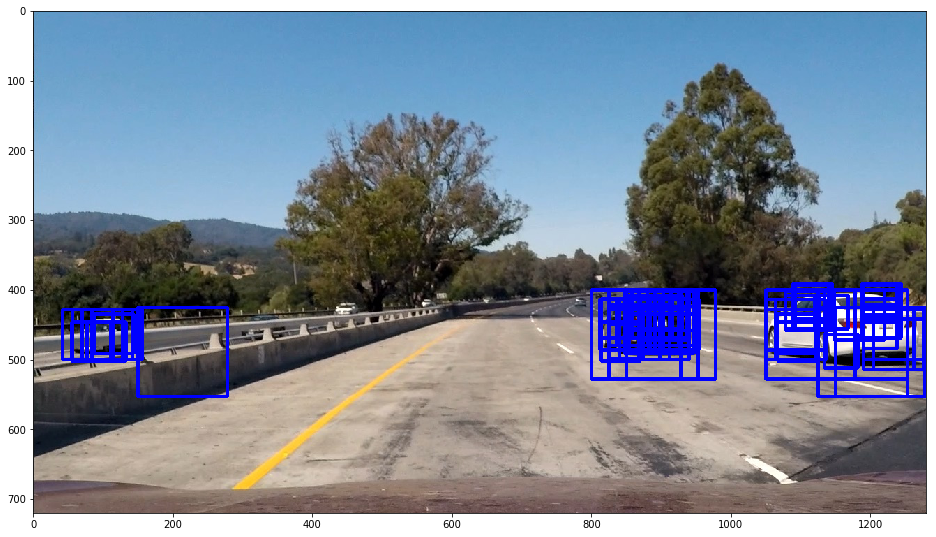

In [102]:
test_image = mpimg.imread('./test_images/test1.jpg')

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
test_image = test_image.astype(np.float32)/255

hot_windows = search_all_sizes_windows(test_image)

window_img = draw_boxes(test_image, hot_windows, color=(0, 0, 1.0), thick=3) 

plt.figure(figsize=(16,10))
plt.imshow(window_img)
plt.show()

**Heatmap**

Creating a heat map and adding "heat" to areas where the classifier made a positive prediction – more overlapping detections were given more heat.  

Since false positive tend to have only one or two overlapping detections, where true positive tend to have several, a threshold was applied to the heatmap and essentially turned off all the weak spots. 

In [105]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

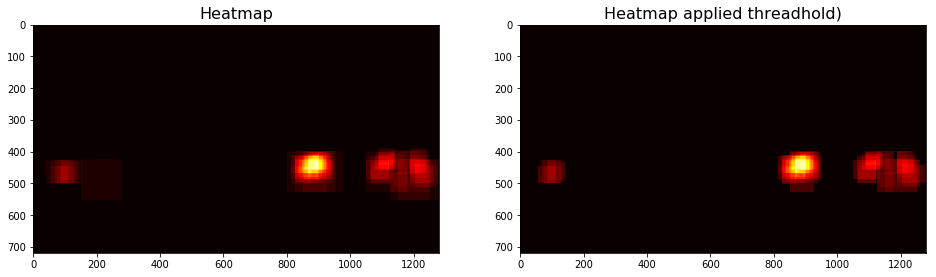

In [106]:
# Read in image similar to one shown above 
heat = np.zeros_like(test_image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat, hot_windows)

# Visualize the heatmap when displaying
heatmap1 = np.clip(heat, 0, 255)

# Apply threshold to help remove false positives
heat = apply_threshold(heat,2)

# Visualize the heatmap when displaying
heatmap2 = np.clip(heat, 0, 255)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
ax1.imshow(heatmap1, cmap='hot')
ax1.set_title('Heatmap', fontsize=16)

ax2.imshow(heatmap2, cmap='hot')
ax2.set_title('Heatmap applied threadhold)', fontsize=16)
plt.show()

Finally, the bounding boxes for individual car are determined by the bounds of the heatmap label. 

In [110]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

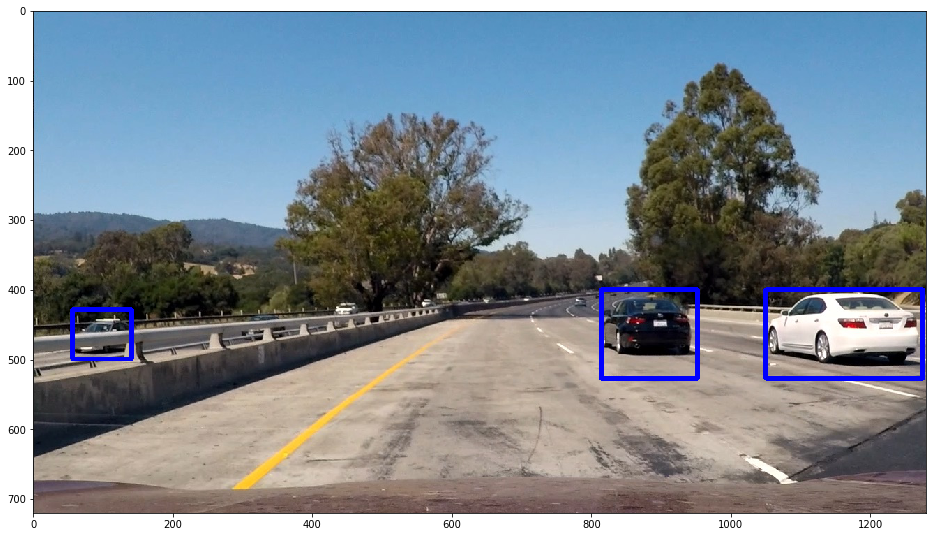

In [111]:
# Find final boxes from heatmap using label function
labels = label(heatmap2)
draw_img = draw_labeled_bboxes(np.copy(test_image), labels)

plt.figure(figsize=(16,10))
plt.imshow(draw_img)
plt.show()

## 4. Test images

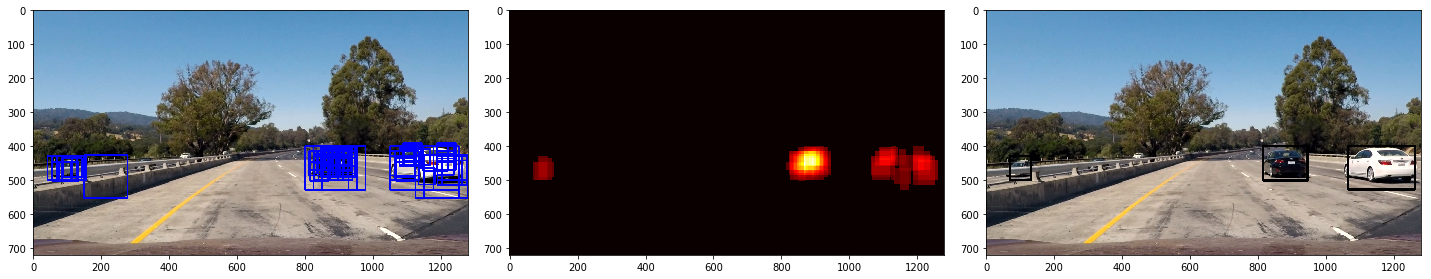

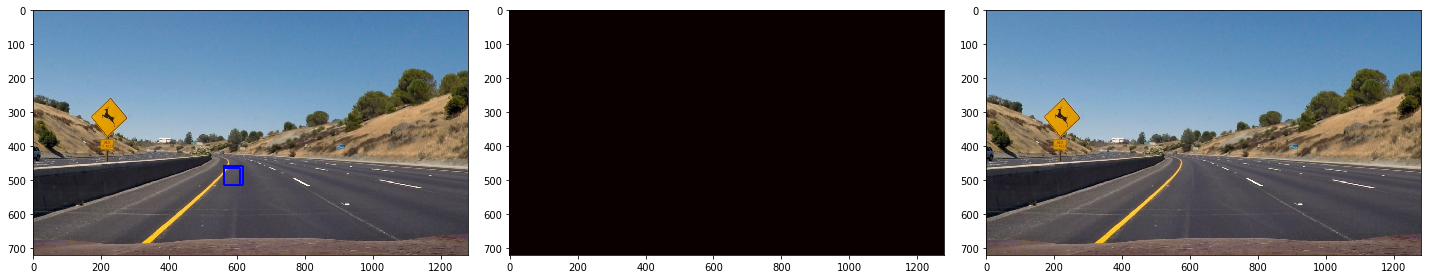

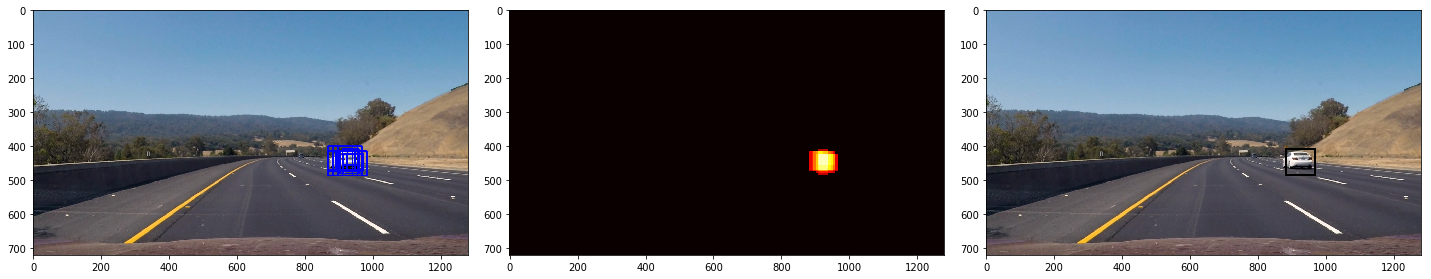

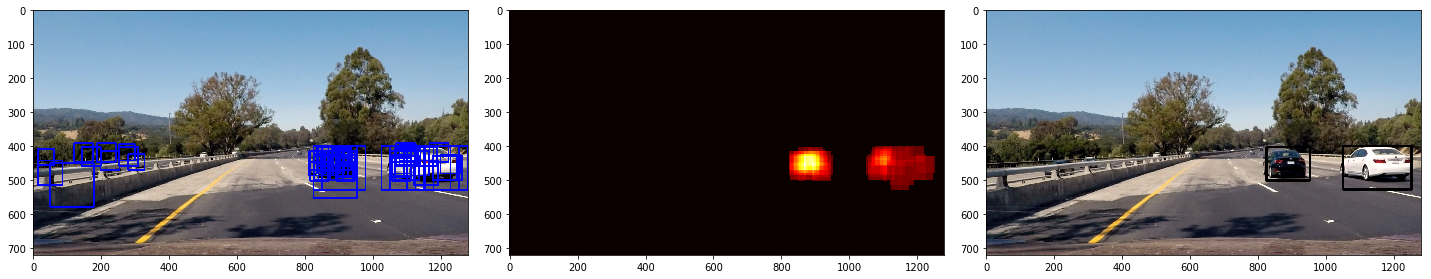

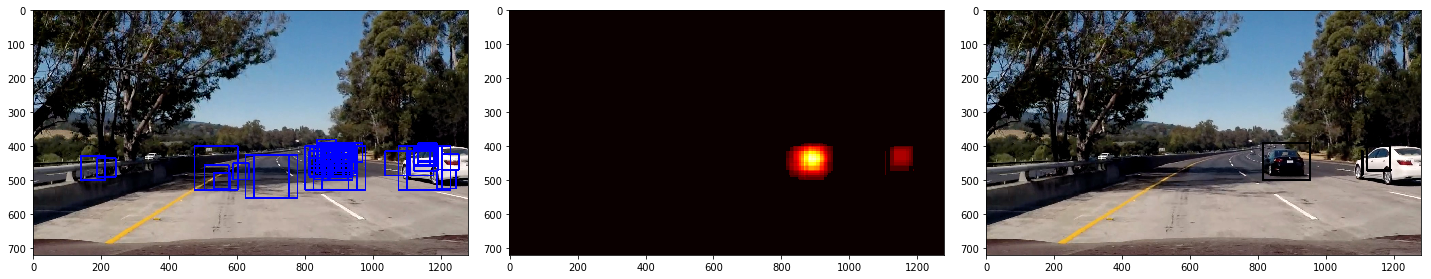

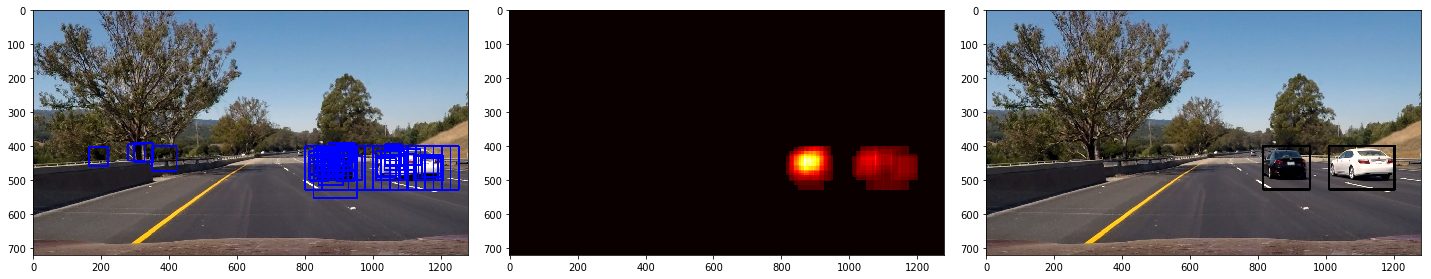

In [113]:
testing_image_names = os.listdir("test_images/")

for image_name in testing_image_names:
    test_image = mpimg.imread('test_images/' + image_name)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    test_image = test_image.astype(np.float32)/255

    hot_windows = search_all_sizes_windows(test_image)

    # Read in image similar to one shown above 
    heat = np.zeros_like(test_image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,3)

    # Visualize the heatmap when displaying
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)

    draw_img = draw_labeled_bboxes(np.copy(test_image), labels)

    window_img = draw_boxes(test_image, hot_windows, color=(0, 0, 1), thick=4)         

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
    f.tight_layout()
    ax1.imshow(window_img)
    ax2.imshow(heatmap, cmap='hot')
    ax3.imshow(draw_img)
    plt.show()

## 5. Video Implementation

In [114]:
def process_image(img):
    test_image = img.astype(np.float32)/255

    hot_windows = search_all_sizes_windows(test_image)

    # Read in image similar to one shown above 
    heatmap = np.zeros_like(test_image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heatmap = add_heat(heatmap, hot_windows)

    # Visualize the heatmap when displaying
    heatmap = np.clip(heatmap, 0, 255)

    heatmap = apply_threshold(heatmap,3)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)

    draw_img = np.copy(img)    
    draw_img = draw_labeled_bboxes(draw_img, labels)
    
    return draw_img

In [118]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

project_output  = 'output_project_video.mp4'
clip1  = VideoFileClip('project_video.mp4')
project_clip = clip1 .fl_image(process_image)

%time project_clip .write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4


100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [4:42:22<00:13, 13.22s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video.mp4 

Wall time: 4h 42min 23s


In [119]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))